In [2]:
# ============================================================
# LIBRARIES
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score,
    average_precision_score,
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

import lightgbm as lgb

In [3]:
# ============================================================
# DATA UPLOAD
# ============================================================
df = pd.read_csv("credit_risk_dataset.csv")

print(df.shape)
print(df.dtypes)
print(df.isnull().sum().sort_values(ascending=False))
df.describe()

(32581, 12)
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object
loan_int_rate                 3116
person_emp_length              895
person_age                       0
person_income                    0
person_home_ownership            0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [4]:
def visualize_data(df, cat_limit=20):
    sns.set_style("whitegrid")
    sns.set_palette("muted")

    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns

    print(f"Numerical: {len(num_cols)} | Categorical: {len(cat_cols)} variables\n")

    for col in num_cols:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f"Numerical: {col}", fontsize=14, fontweight='bold')

        sns.histplot(df[col], kde=True, ax=ax1, color='skyblue')
        ax1.set(title="Distribution", xlabel=col, ylabel="Frequency")

        sns.boxplot(x=df[col], ax=ax2, color='lightgreen')
        ax2.set(title="Outliers", xlabel=col)

        plt.tight_layout()
        plt.show()

    for col in cat_cols:
        if df[col].nunique() > cat_limit:
            print(f"⚠️ '{col}' skipped ({df[col].nunique()} unique values > limit {cat_limit})")
            continue

        fig, ax = plt.subplots(figsize=(10, 5))
        sns.countplot(
            data=df,
            x=col,
            order=df[col].value_counts().index,
            hue=col,
            palette="viridis",
            legend=False,
            ax=ax
        )

        ax.set(title=f"Categorical: {col}", xlabel=col, ylabel="Count")
        ax.bar_label(ax.containers[0])
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    print("Completed.")

Numerical: 8 | Categorical: 4 variables



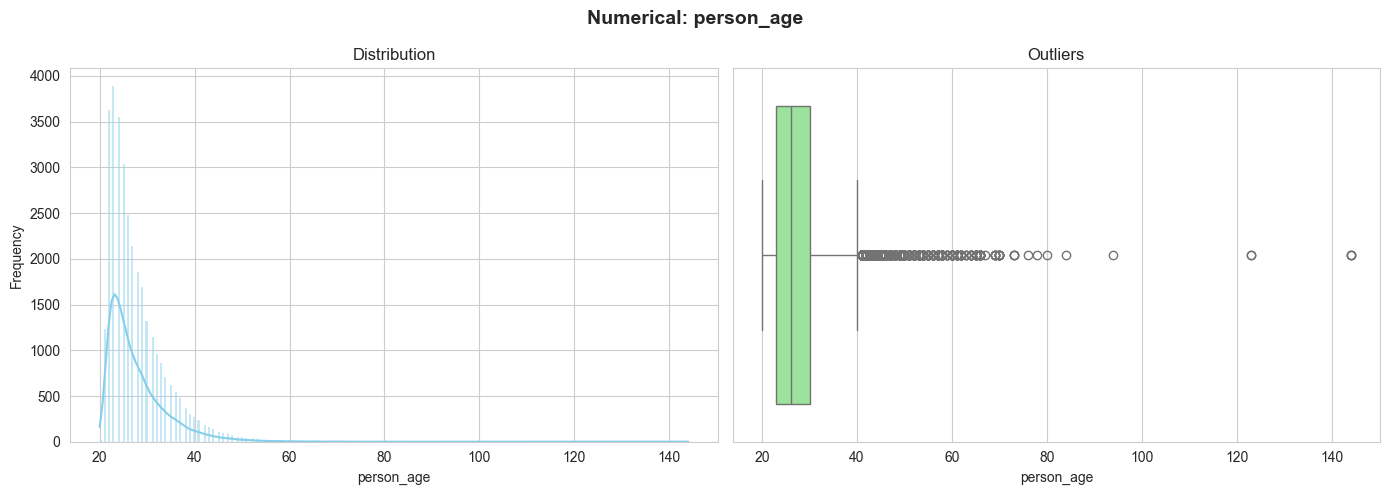

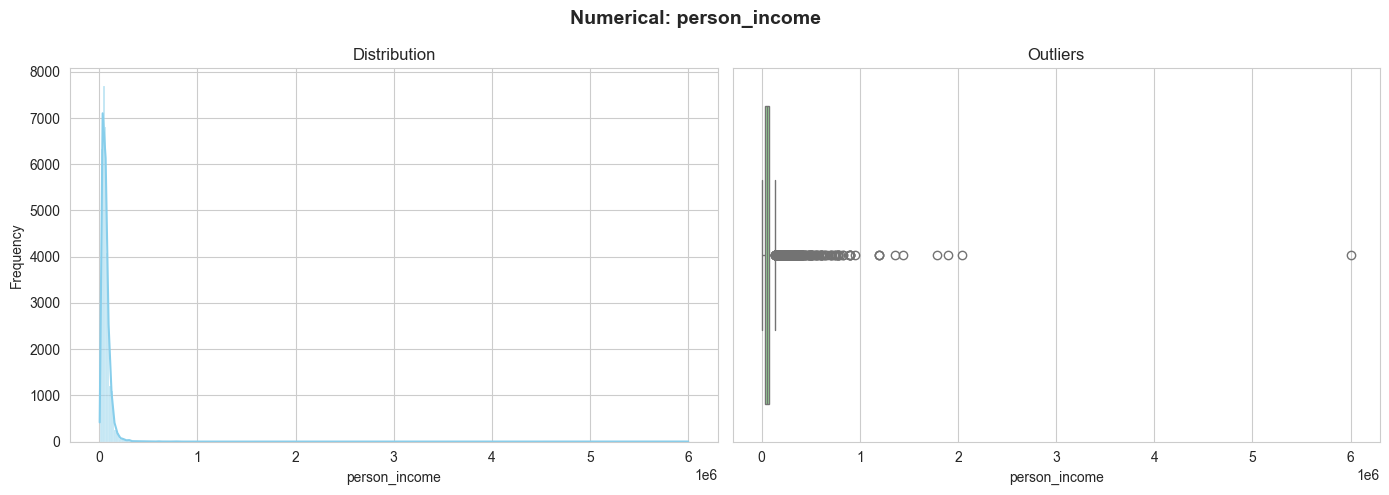

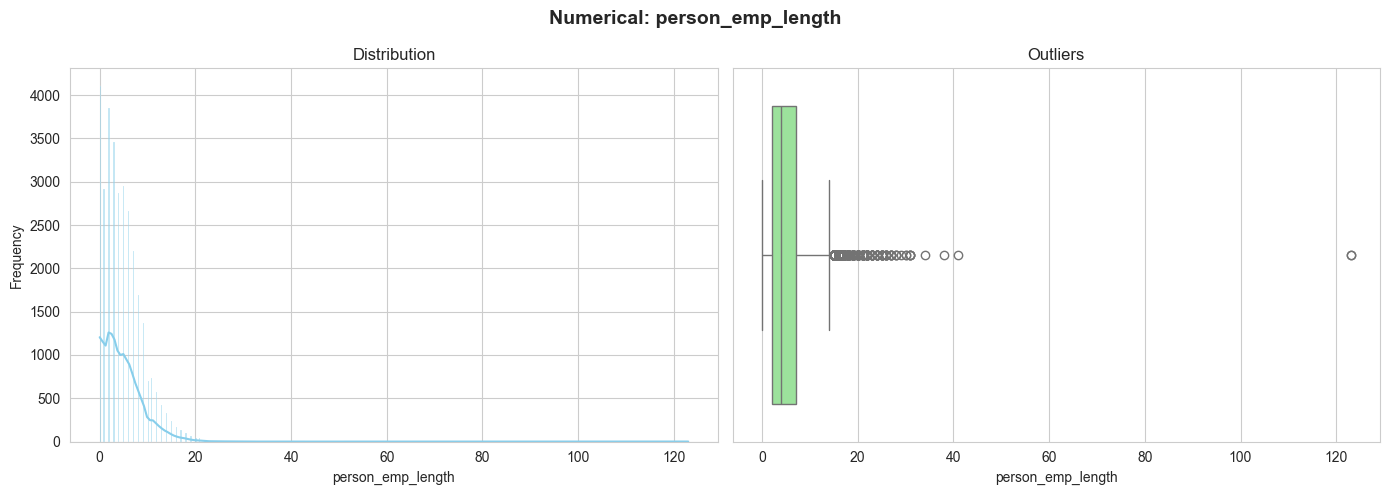

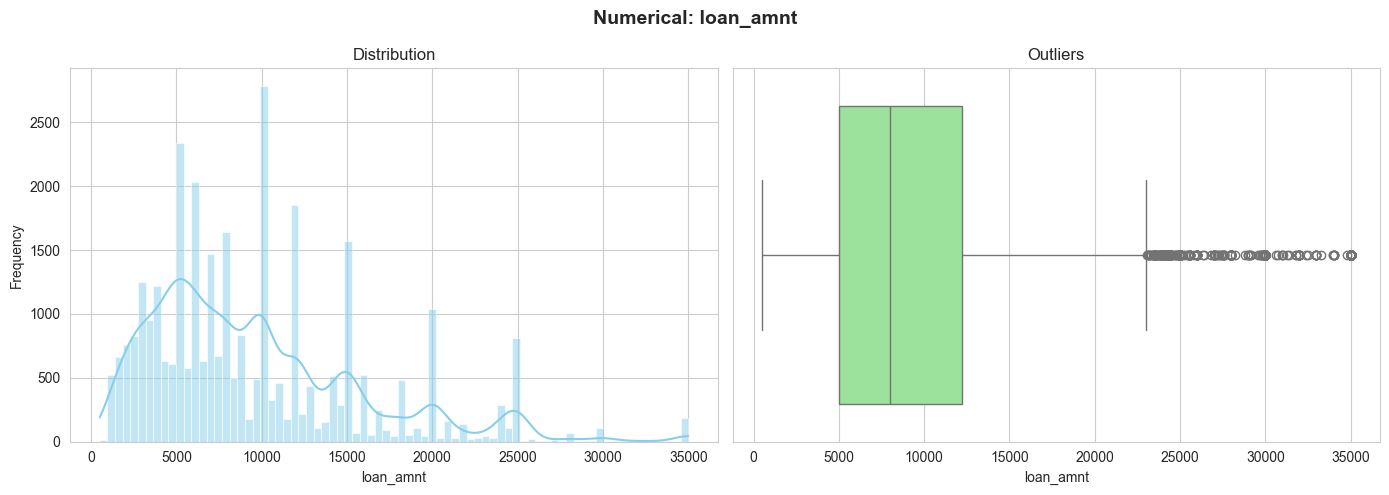

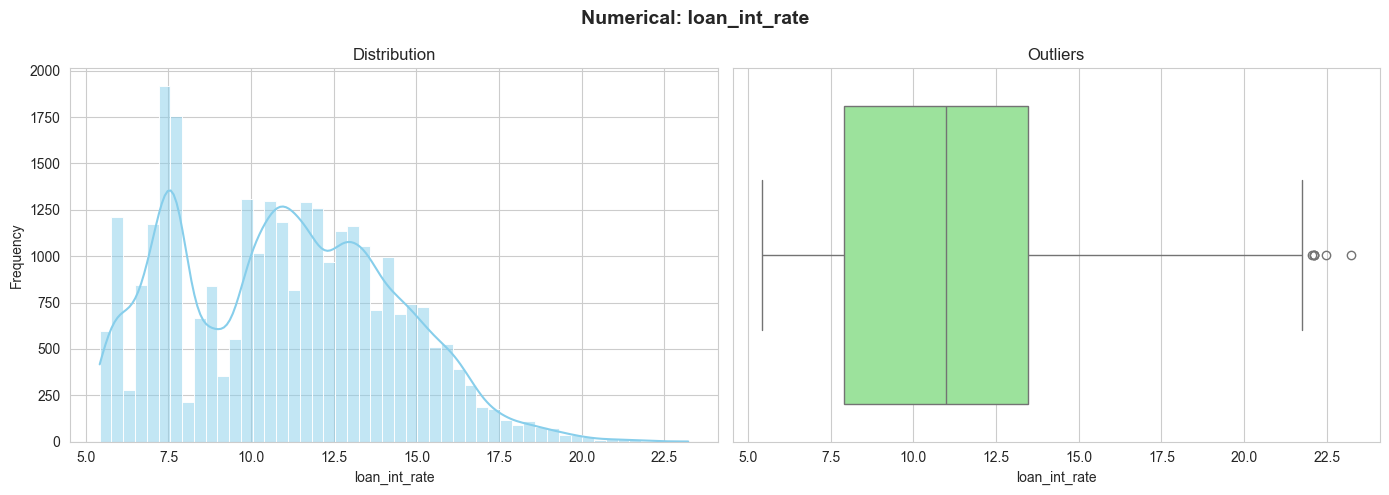

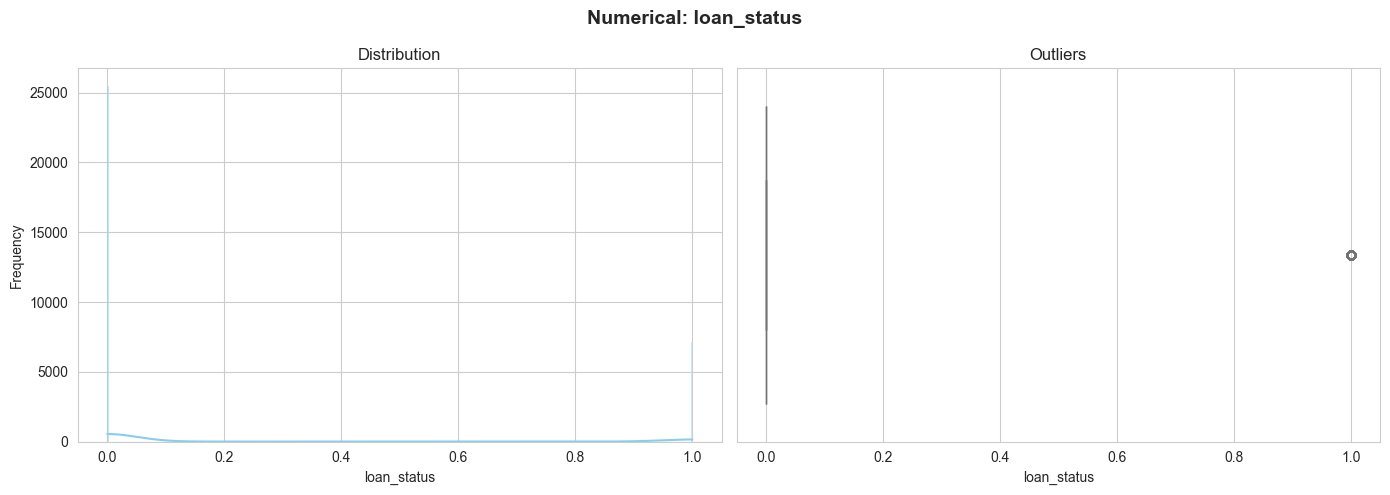

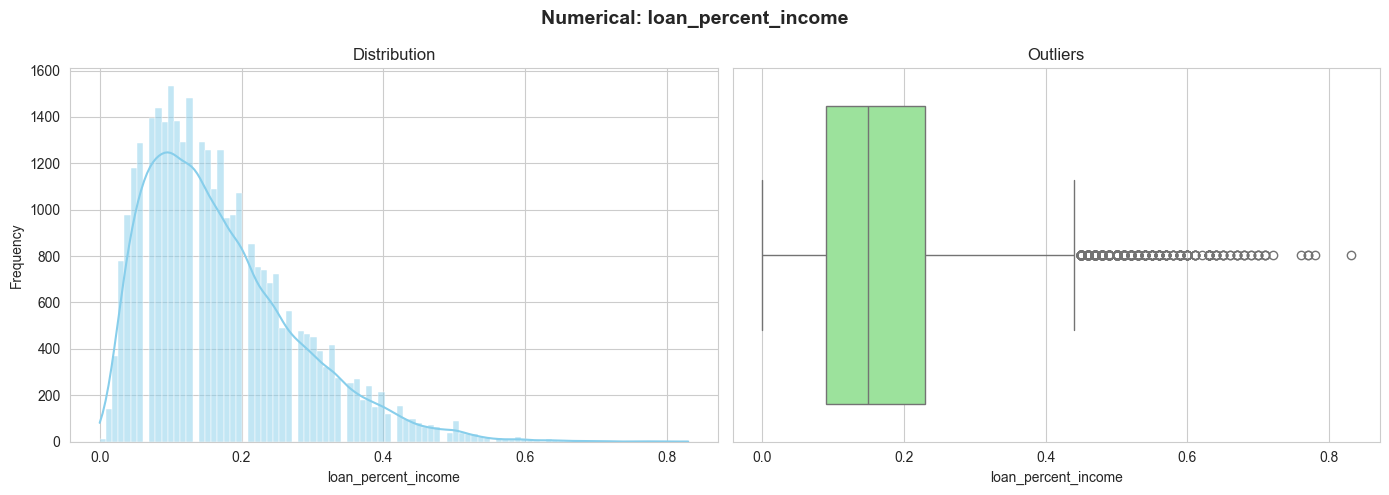

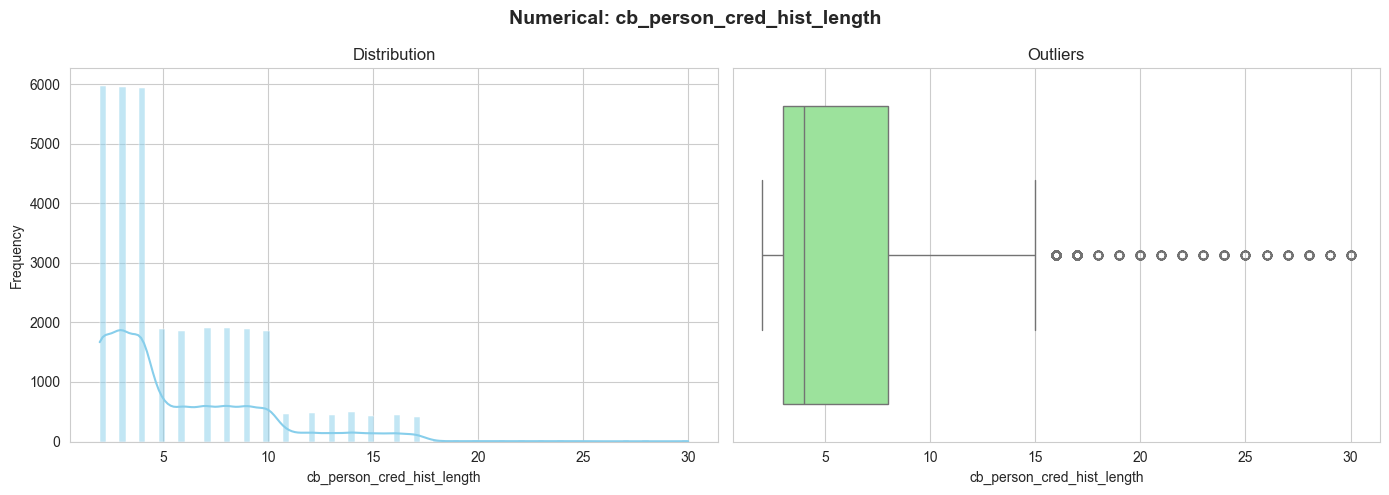

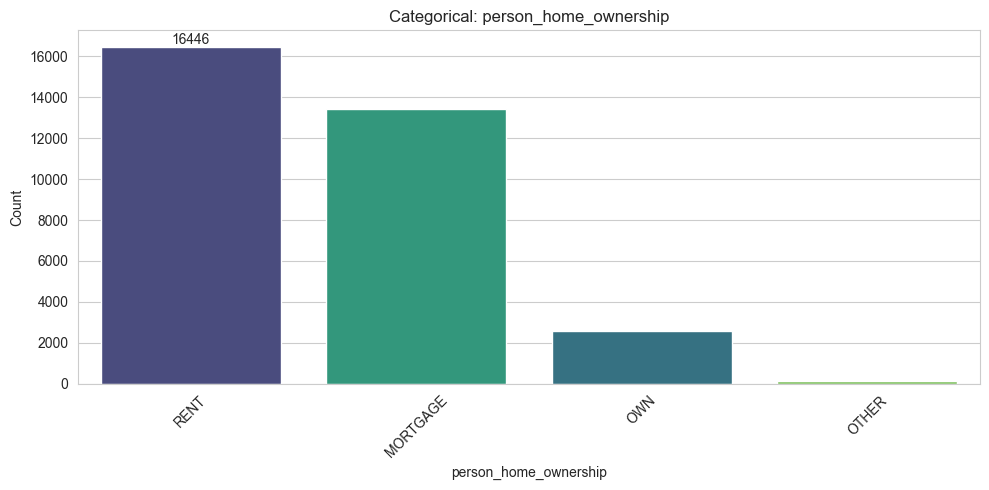

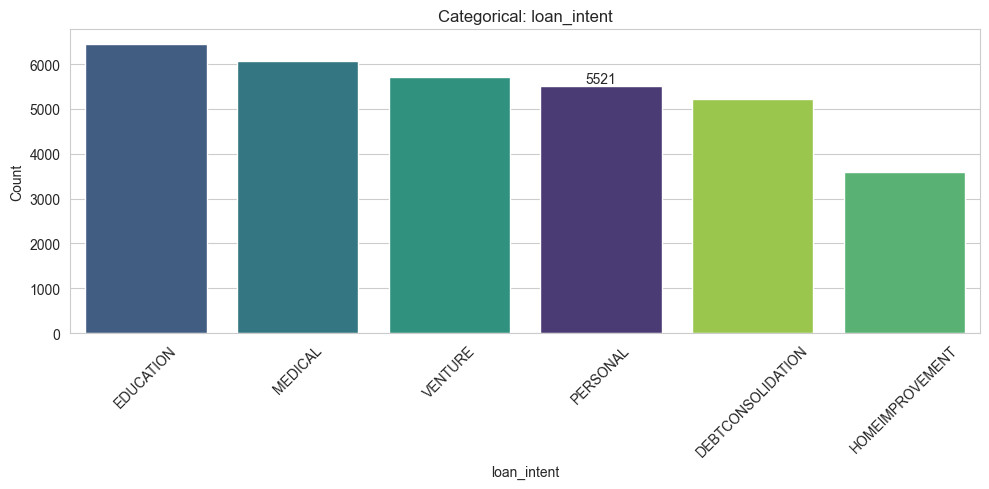

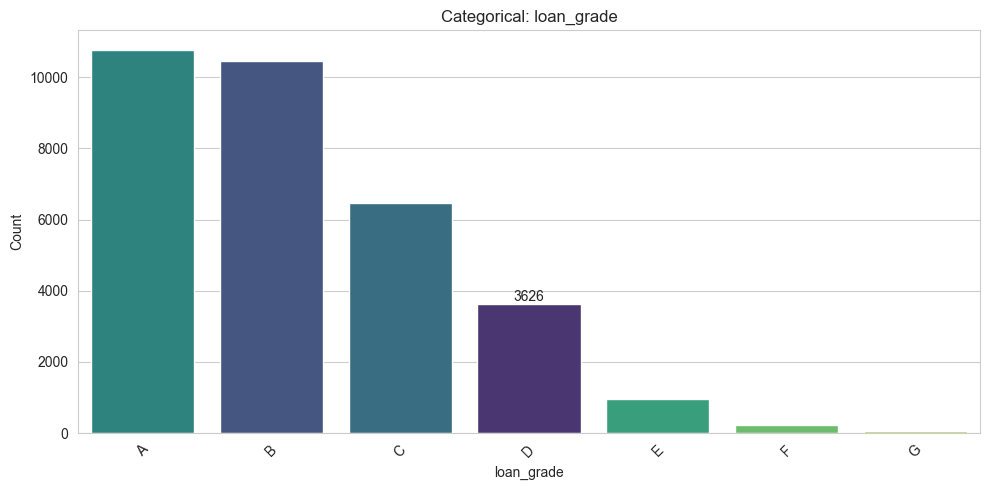

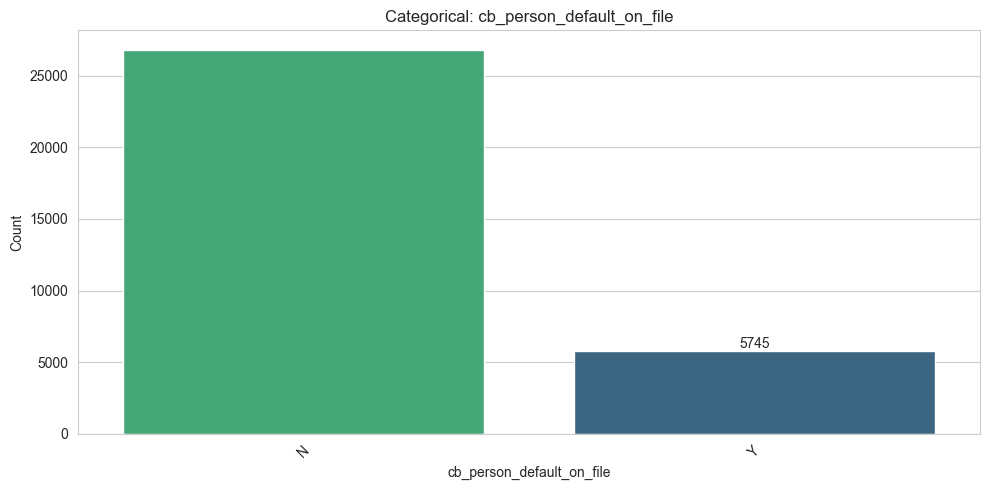

Completed.


In [5]:
visualize_data(df)

# ============================================================
# TRAIN / TEST SPLIT
# ============================================================

In [7]:
X = df.drop("loan_status", axis=1).copy()
y = df["loan_status"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print(f"Target distribution (train): {y_train.value_counts(normalize=True).round(3).to_dict()}")
print(f"Target distribution (test) : {y_test.value_counts(normalize=True).round(3).to_dict()}")

Train: (26064, 11) | Test: (6517, 11)
Target distribution (train): {0: 0.782, 1: 0.218}
Target distribution (test) : {0: 0.782, 1: 0.218}


At this step, instead of deleting outliers, I set them to NaN. The goal is to reduce the distortion of model coefficients or tree splits caused by data entry errors or extreme records.

The values converted to NaN are imputed within the pipeline using median/most_frequent learned from the train fold. This prevents validation fold information from leaking into preprocessing during cross-validation.

Outlier thresholds were not automatically derived from 5σ; they were defined as fixed limits based on domain knowledge and data inspection. (Alternatively, IQR/quantile-based automatic thresholding could be tested.)

Log transformations (log1p) aim to improve linear model stability by compressing the scale of heavily right-skewed distributions.

Binning converts nonlinear relationships into coarse segments; it carries a risk of information loss → its impact should be checked via ablation.

In [8]:
# ── 1. OUTLİER
outlier_limits = {
    'person_age'       : 60,
    'person_income'    : 225200,
    'person_emp_length': 40,
}
for col, limit in outlier_limits.items():
    X_train.loc[X_train[col] > limit, col] = np.nan
    X_test.loc[X_test[col] > limit, col]   = np.nan


# ── 3. ENCODING —
grade_map   = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7}
default_map = {'Y':1,'N':0}

for df_ in [X_train, X_test]:
    df_['loan_grade']                = df_['loan_grade'].map(grade_map)
    df_['cb_person_default_on_file'] = df_['cb_person_default_on_file'].map(default_map)

# ── 4. FEATURE ENGINEERING — log
for df_ in [X_train, X_test]:
    df_['person_income_log'] = np.log1p(df_['person_income'])
    df_['loan_amnt_log']     = np.log1p(df_['loan_amnt'])

# ── 5. BIN'LEME —
inc_bins  = [0, 0.20, 0.35, 0.50, np.inf]
rate_bins = [0, 8, 12, 16, np.inf]
emp_bins  = [0, 1, 3, 7, 15, np.inf]
age_bins  = [0, 25, 35, 50, np.inf]

for df_ in [X_train, X_test]:
    df_['loan_percent_group'] = pd.cut(df_['loan_percent_income'], bins=inc_bins,
                                       labels=[1,2,3,4], include_lowest=True).astype(float)
    df_['int_rate_group']     = pd.cut(df_['loan_int_rate'], bins=rate_bins,
                                       labels=[1,2,3,4], include_lowest=True).astype(float)
    df_['emp_length_group']   = pd.cut(df_['person_emp_length'], bins=emp_bins,
                                       labels=[1,2,3,4,5], include_lowest=True).astype(float)
    df_['age_group']          = pd.cut(df_['person_age'], bins=age_bins,
                                       labels=[1,2,3,4], include_lowest=True).astype(float)

cat_cols = ['person_home_ownership', 'loan_intent']
num_cols = [c for c in X_train.columns if c not in cat_cols]

# ── CONTROL
print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print(f"Train NaN: {X_train.isnull().sum().sum()} | Test NaN: {X_test.isnull().sum().sum()}")
print(f"Column matching: {list(X_train.columns) == list(X_test.columns)}")

Train: (26064, 17) | Test: (6517, 17)
Train NaN: 7118 | Test NaN: 1702
Kolon eşleşmesi: True


# ============================================================
# LOGISTIC REGRESSION
# ============================================================

I chose Logistic Regression as the baseline because it provides a fast sanity check and is interpretable through its coefficients (which features increase/decrease risk).

In an imbalanced setting, `class_weight="balanced"` helps shift the decision boundary to reduce missing the minority class (false negatives).

Scaling is necessary: L2 regularization is scale-sensitive; unscaled features can unnecessarily inflate coefficients.

This model is not the “final” one—it serves as a reference to evaluate whether more complex models truly add value.

=== LOGISTIC REGRESSION — TEST RESULTS ===
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      5095
           1       0.54      0.79      0.64      1422

    accuracy                           0.81      6517
   macro avg       0.74      0.80      0.75      6517
weighted avg       0.85      0.81      0.82      6517

ROC-AUC : 0.8763
PR-AUC  : 0.7177


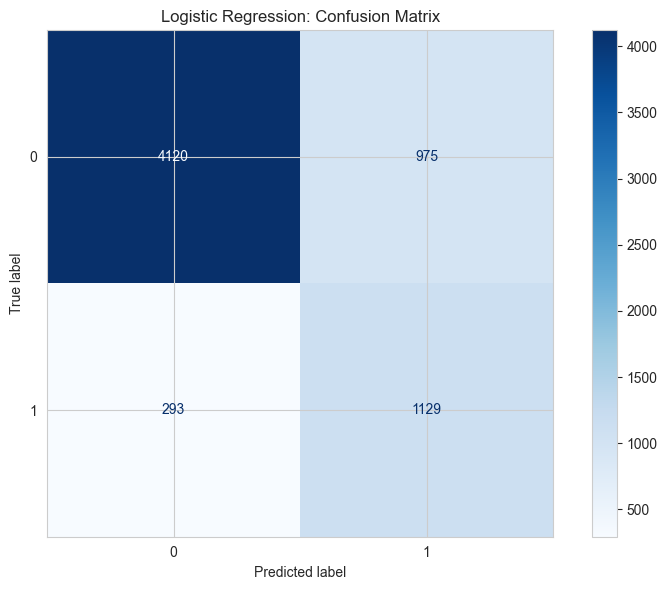

In [9]:
# ===== Preprocess (LR : impute + scale + onehot) =====
preprocess_lr = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore")),
        ]), cat_cols),
    ],
    remainder="drop"
)

# ===== Preprocess (Tree: impute + onehot) =====
preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore")),
        ]), cat_cols),
    ],
    remainder="drop"
)

# ===== Logistic Regression pipeline =====
lr_pipe = Pipeline([
    ("prep", preprocess_lr),
    ("model", LogisticRegression(
        class_weight="balanced",
        solver="saga",
        max_iter=2000,
        random_state=42
    ))
])

lr_pipe.fit(X_train, y_train)

y_pred_lr = lr_pipe.predict(X_test)
y_prob_lr = lr_pipe.predict_proba(X_test)[:, 1]

print("=== LOGISTIC REGRESSION — TEST RESULTS ===")
print(classification_report(y_test, y_pred_lr))
print(f"ROC-AUC : {roc_auc_score(y_test, y_prob_lr):.4f}")
print(f"PR-AUC  : {average_precision_score(y_test, y_prob_lr):.4f}")

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=ax, cmap="Blues")
plt.title("Logistic Regression: Confusion Matrix")
plt.tight_layout()
plt.show()

# ============================================================
# LightGBM — BASELINE MODEL
# ============================================================

I used LightGBM because, in tabular data, I expect interactions and nonlinear relationships; its tree-based structure is scale-invariant and automatically captures feature interactions.

The goal is to capture nonlinearities that Logistic Regression may miss and improve generalization performance.

I evaluate performance not only with accuracy, but also with ROC-AUC for ranking power and PR-AUC for imbalanced classification settings.

In [10]:
lgbm_pipe_baseline = Pipeline([
    ("prep", preprocess_tree),
    ("model", lgb.LGBMClassifier(
        class_weight="balanced",
        n_estimators=100,
        random_state=42,
        verbose=-1
    ))
])

lgbm_pipe_baseline.fit(X_train, y_train)

y_pred_lgbm_train = lgbm_pipe_baseline.predict(X_train)
y_prob_lgbm_train = lgbm_pipe_baseline.predict_proba(X_train)[:, 1]

y_pred_lgbm_test  = lgbm_pipe_baseline.predict(X_test)
y_prob_lgbm_test  = lgbm_pipe_baseline.predict_proba(X_test)[:, 1]

print("=== LightGBM BASELINE — TRAIN SET ===")
print(classification_report(y_train, y_pred_lgbm_train))
print(f"ROC-AUC : {roc_auc_score(y_train, y_prob_lgbm_train):.4f}")
print(f"PR-AUC  : {average_precision_score(y_train, y_prob_lgbm_train):.4f}")

print("\n=== LightGBM BASELINE — TEST SET ===")
print(classification_report(y_test, y_pred_lgbm_test))
print(f"ROC-AUC : {roc_auc_score(y_test, y_prob_lgbm_test):.4f}")
print(f"PR-AUC  : {average_precision_score(y_test, y_prob_lgbm_test):.4f}")

=== LightGBM BASELINE — TRAIN SET ===
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     20378
           1       0.87      0.85      0.86      5686

    accuracy                           0.94     26064
   macro avg       0.91      0.91      0.91     26064
weighted avg       0.94      0.94      0.94     26064

ROC-AUC : 0.9755
PR-AUC  : 0.9430

=== LightGBM BASELINE — TEST SET ===
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5095
           1       0.84      0.80      0.82      1422

    accuracy                           0.92      6517
   macro avg       0.89      0.88      0.89      6517
weighted avg       0.92      0.92      0.92      6517

ROC-AUC : 0.9501
PR-AUC  : 0.9060


# ============================================================
# HYPERPARAMETER OPTIMIZATION — OVERFITTING CONTROL
# ============================================================

I use RandomizedSearchCV to explore a wide hyperparameter space efficiently within limited time and identify promising regions.

`max_depth` and `num_leaves` control model flexibility (and variance risk), `min_child_samples` controls leaf stability, while `reg_alpha` and `reg_lambda` handle regularization.

I chose ROC-AUC as the scoring metric because it is threshold-independent and measures the model’s risk ranking quality; the final threshold will be selected separately based on business objectives.

Since preprocessing is included inside the cross-validation pipeline, scores are compared more fairly across folds.

In [11]:
lgbm_base_pipe = Pipeline([
    ("prep", preprocess_tree),
    ("model", lgb.LGBMClassifier(
        class_weight="balanced",
        random_state=42,
        verbose=-1
    ))
])

param_dist = {
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [3, 4, 5],
    "model__num_leaves": [15, 20, 31],
    "model__min_child_samples": [50, 100, 150],
    "model__subsample": [0.6, 0.7, 0.8],
    "model__colsample_bytree": [0.6, 0.7, 0.8],
    "model__reg_alpha": [0.1, 0.5, 1.0],
    "model__reg_lambda": [0.1, 0.5, 1.0],
}

random_search = RandomizedSearchCV(
    estimator=lgbm_base_pipe,
    param_distributions=param_dist,
    n_iter=50,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("CV ROC-AUC     :", round(random_search.best_score_, 4))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'model__subsample': 0.8, 'model__reg_lambda': 0.1, 'model__reg_alpha': 0.1, 'model__num_leaves': 15, 'model__n_estimators': 300, 'model__min_child_samples': 50, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}
CV ROC-AUC     : 0.9464


# ============================================================
# TUNED LightGBM — TRAIN vs TEST
# ============================================================

The goal is to control overfitting (bias–variance tradeoff).

`max_depth` and `num_leaves` control model capacity, `min_child_samples` controls leaf stability, and `reg_alpha`/`reg_lambda` control regularization.

=== TUNED LightGBM — TRAIN SET ===
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     20378
           1       0.85      0.86      0.85      5686

    accuracy                           0.93     26064
   macro avg       0.90      0.91      0.90     26064
weighted avg       0.93      0.93      0.93     26064

ROC-AUC : 0.9745
PR-AUC  : 0.9409

=== TUNED LightGBM — TEST SET ===
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5095
           1       0.82      0.81      0.81      1422

    accuracy                           0.92      6517
   macro avg       0.88      0.88      0.88      6517
weighted avg       0.92      0.92      0.92      6517

ROC-AUC : 0.9527
PR-AUC  : 0.9084


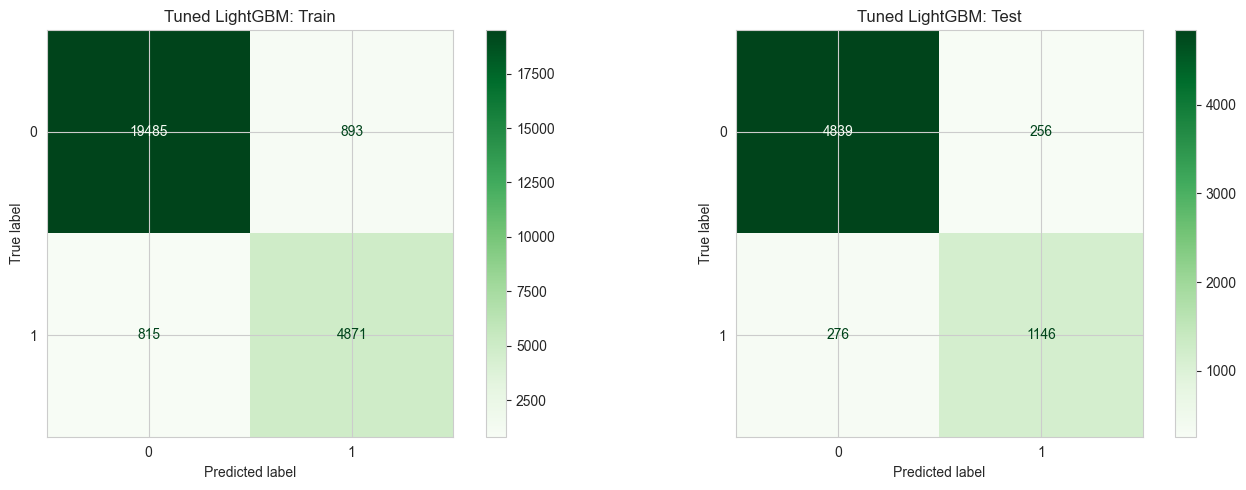

In [12]:
best_lgbm = random_search.best_estimator_

y_pred_tuned_train = best_lgbm.predict(X_train)
y_prob_tuned_train = best_lgbm.predict_proba(X_train)[:, 1]

y_pred_tuned_test = best_lgbm.predict(X_test)
y_prob_tuned_test = best_lgbm.predict_proba(X_test)[:, 1]

print("=== TUNED LightGBM — TRAIN SET ===")
print(classification_report(y_train, y_pred_tuned_train))
print(f"ROC-AUC : {roc_auc_score(y_train, y_prob_tuned_train):.4f}")
print(f"PR-AUC  : {average_precision_score(y_train, y_prob_tuned_train):.4f}")

print("\n=== TUNED LightGBM — TEST SET ===")
print(classification_report(y_test, y_pred_tuned_test))
print(f"ROC-AUC : {roc_auc_score(y_test, y_prob_tuned_test):.4f}")
print(f"PR-AUC  : {average_precision_score(y_test, y_prob_tuned_test):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_tuned_train, ax=axes[0], cmap="Greens")
axes[0].set_title("Tuned LightGBM: Train")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned_test, ax=axes[1], cmap="Greens")
axes[1].set_title("Tuned LightGBM: Test")

plt.tight_layout()
plt.show()

# ============================================================
# STACKING CLASSIFIER
# ============================================================

In [13]:
best_model_params = {
    k.replace("model__", ""): v
    for k, v in random_search.best_params_.items()
    if k.startswith("model__")
}

base_models = [
    ("lr", Pipeline([
        ("prep", preprocess_lr),
        ("model", LogisticRegression(
            C=0.1,
            penalty="l2",
            class_weight="balanced",
            solver="saga",
            max_iter=2000,
            random_state=42
        ))
    ])),
    ("lgbm", Pipeline([
        ("prep", preprocess_tree),
        ("model", lgb.LGBMClassifier(
            **best_model_params,
            class_weight="balanced",
            random_state=42,
            verbose=-1
        ))
    ])),
]

meta_model = lgb.LGBMClassifier(
    class_weight="balanced",
    n_estimators=100,
    max_depth=3,
    num_leaves=15,
    random_state=42,
    verbose=-1
)

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)

y_pred_stack_train = stacking_clf.predict(X_train)
y_prob_stack_train = stacking_clf.predict_proba(X_train)[:, 1]
y_pred_stack_test  = stacking_clf.predict(X_test)
y_prob_stack_test  = stacking_clf.predict_proba(X_test)[:, 1]

print("=== STACKING — TEST SET ===")
print(classification_report(y_test, y_pred_stack_test))
print(f"ROC-AUC : {roc_auc_score(y_test, y_prob_stack_test):.4f}")
print(f"PR-AUC  : {average_precision_score(y_test, y_prob_stack_test):.4f}")

=== STACKING — TEST SET ===
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      5095
           1       0.77      0.84      0.80      1422

    accuracy                           0.91      6517
   macro avg       0.86      0.88      0.87      6517
weighted avg       0.91      0.91      0.91      6517

ROC-AUC : 0.9523
PR-AUC  : 0.9081


# ============================================================
# MODEL COMPARISON (TEST SET)
# ============================================================

I aim to select the model based on cross-validation results rather than tuning on the test set.

The test set should be used only once at the very end for the final report; otherwise, performance estimates may become optimistically biased.

Therefore, the “best model” decision is made by jointly evaluating CV ROC-AUC / PR-AUC together with business objectives (cost of FN vs FP).

In [14]:
models = {
    "Logistic Regression": (y_pred_lr, y_prob_lr),
    "LightGBM Baseline": (y_pred_lgbm_test, y_prob_lgbm_test),
    "LightGBM Tuned": (y_pred_tuned_test, y_prob_tuned_test),
    "Stacking": (y_pred_stack_test, y_prob_stack_test),
}

rows = []
for model_name, (y_pred, y_prob) in models.items():
    rows.append({
        "Model": model_name,
        "F1 (class 1)": round(f1_score(y_test, y_pred), 4),
        "ROC-AUC": round(roc_auc_score(y_test, y_prob), 4),
        "PR-AUC": round(average_precision_score(y_test, y_prob), 4),
    })

summary_df = (
    pd.DataFrame(rows)
    .sort_values("F1 (class 1)", ascending=False)
    .reset_index(drop=True)
)

print(summary_df.to_string(index=False))

              Model  F1 (class 1)  ROC-AUC  PR-AUC
  LightGBM Baseline        0.8201   0.9501  0.9060
     LightGBM Tuned        0.8116   0.9527  0.9084
           Stacking        0.8032   0.9523  0.9081
Logistic Regression        0.6404   0.8763  0.7177


# ============================================================
# OPTIMAL THRESHOLD
# ============================================================

A threshold is required to convert predicted probabilities into class labels.

I select the threshold on cross-validation by maximizing F1, aiming to optimize the precision–recall balance with a single metric.

The test set is not used for threshold selection; it is applied only once for final reporting.

CV Optimal Threshold: 0.7190
CV Optimal Threshold: 0.7190

=== TUNED LightGBM — OPTIMAL THRESHOLD — TEST SET ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.96      0.73      0.83      1422

    accuracy                           0.93      6517
   macro avg       0.94      0.86      0.89      6517
weighted avg       0.94      0.93      0.93      6517



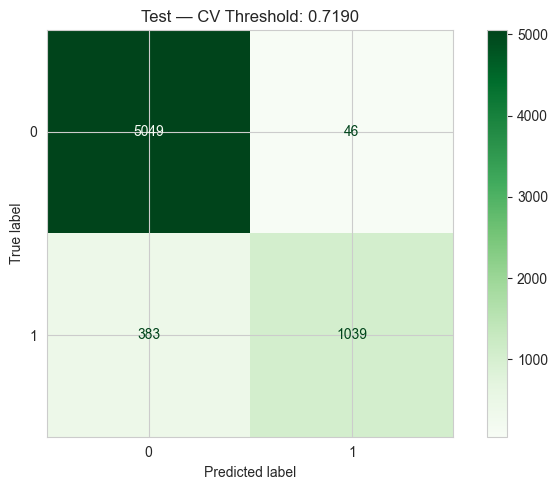

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.base import clone

def cv_optimal_threshold(model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    best_thresholds = []

    for tr_idx, val_idx in skf.split(X, y):
        m = clone(model)
        m.fit(X.iloc[tr_idx], y.iloc[tr_idx])

        probs = m.predict_proba(X.iloc[val_idx])[:, 1]
        prec, rec, thresh = precision_recall_curve(y.iloc[val_idx], probs)

        f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-9)
        best_thresholds.append(thresh[np.argmax(f1)])

    return float(np.mean(best_thresholds))

best_threshold = cv_optimal_threshold(best_lgbm, X_train, y_train)
print(f"CV Optimal Threshold: {best_threshold:.4f}")

best_lgbm.fit(X_train, y_train)

y_pred_final_test = (best_lgbm.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

print(f"CV Optimal Threshold: {best_threshold:.4f}")

best_lgbm.fit(X_train, y_train)

y_pred_final_test = (
    best_lgbm.predict_proba(X_test)[:, 1] >= best_threshold
).astype(int)

print("\n=== TUNED LightGBM — OPTIMAL THRESHOLD — TEST SET ===")
print(classification_report(y_test, y_pred_final_test))

fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final_test, ax=ax, cmap="Greens")
ax.set_title(f"Test — CV Threshold: {best_threshold:.4f}")
plt.tight_layout()
plt.show()

# ============================================================
# FEATURE IMPORTANCE
# ============================================================

“Split importance” shows how many times a feature is used for splitting, while “Gain importance” reflects the total contribution in terms of information gain; they are not the same.

High-cardinality or noisy features may appear important in split counts, so I validate feature importance with SHAP.

The goal is not only to answer “which feature is important?” but also “in which direction does it affect the prediction?”

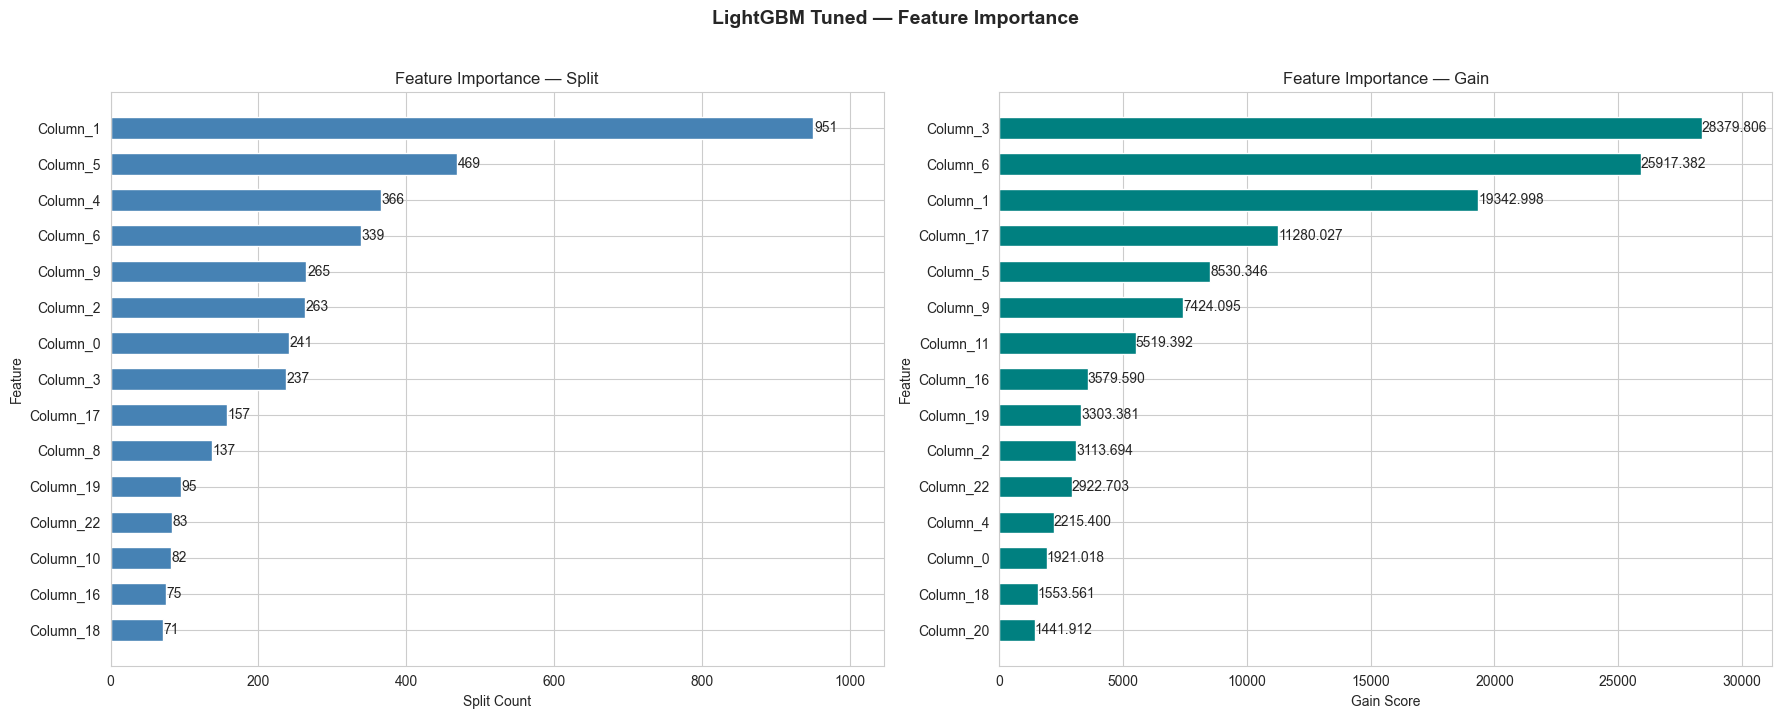

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# SPLIT
lgb.plot_importance(
    best_lgbm.named_steps["model"],
    ax=axes[0],
    max_num_features=15,
    importance_type="split",
    title="Feature Importance — Split",
    xlabel="Split Count",
    ylabel="Feature",
    color="steelblue",
    height=0.6
)

# GAIN
lgb.plot_importance(
    best_lgbm.named_steps["model"],
    ax=axes[1],
    max_num_features=15,
    importance_type="gain",
    title="Feature Importance — Gain",
    xlabel="Gain Score",
    ylabel="Feature",
    color="teal",
    height=0.6
)

plt.suptitle("LightGBM Tuned — Feature Importance", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

SHAP provides the contribution of each feature to the prediction for every observation; this allows me to see not only feature importance ranking but also the direction of effect (risk ↑ / ↓).

With a beeswarm plot, I can read:
(1) the most influential variables,
(2) the impact of high vs. low feature values,
(3) possible interaction patterns.

I use this output not only to explain the model, but also to connect it to policy actions (e.g., which segments are riskier?).

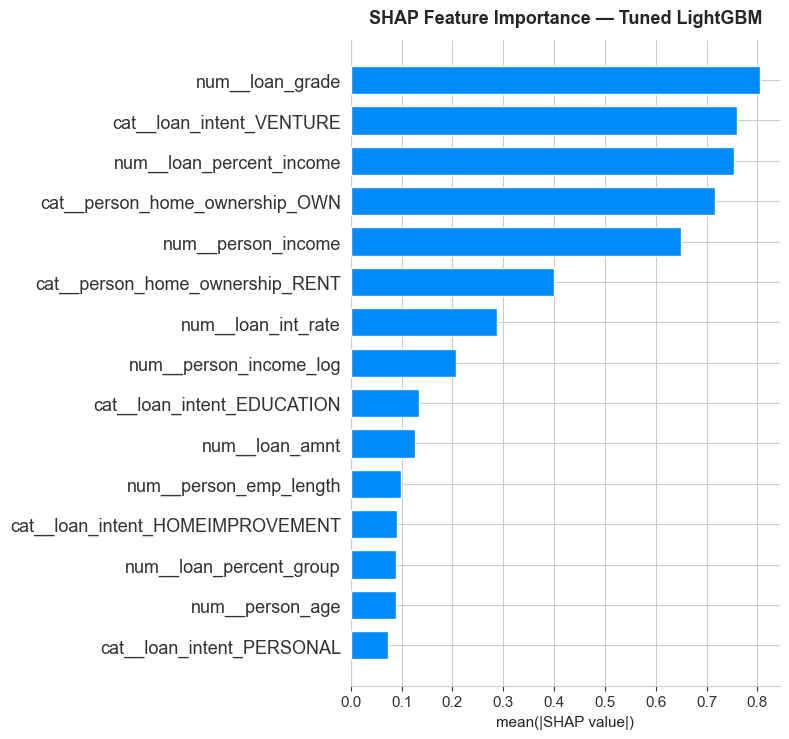

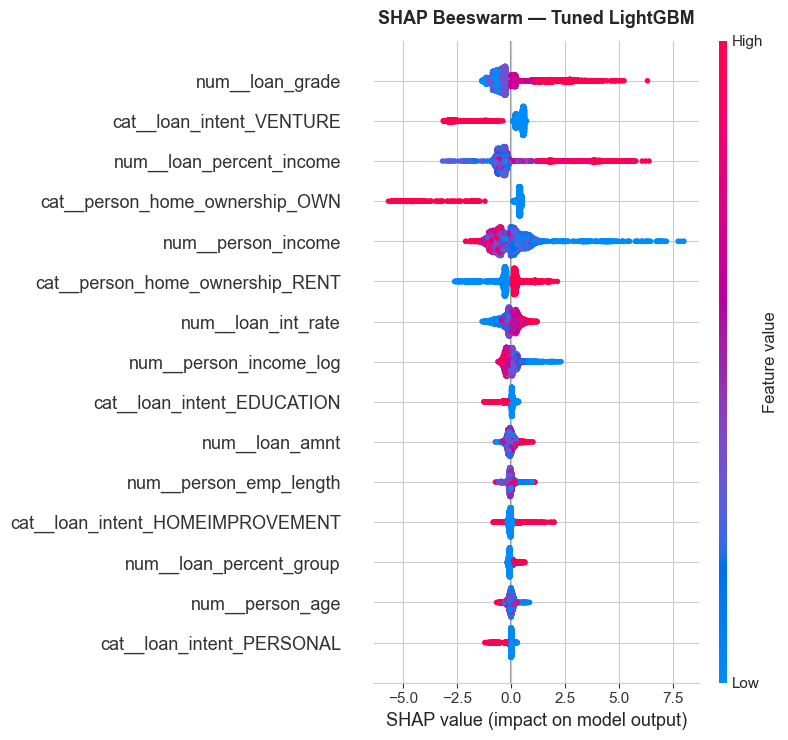


Top 15 Features — SHAP Ranking:
                         feature  mean_abs_shap
                 num__loan_grade         0.8042
        cat__loan_intent_VENTURE         0.7604
        num__loan_percent_income         0.7542
  cat__person_home_ownership_OWN         0.7172
              num__person_income         0.6490
 cat__person_home_ownership_RENT         0.3995
              num__loan_int_rate         0.2875
          num__person_income_log         0.2070
      cat__loan_intent_EDUCATION         0.1340
                  num__loan_amnt         0.1267
          num__person_emp_length         0.0983
cat__loan_intent_HOMEIMPROVEMENT         0.0909
         num__loan_percent_group         0.0890
                 num__person_age         0.0883
       cat__loan_intent_PERSONAL         0.0740


In [19]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import scipy.sparse as sp

warnings.filterwarnings('ignore', category=UserWarning, module='shap')

# Pipeline içinden parçaları al
prep  = best_lgbm.named_steps["prep"]
model = best_lgbm.named_steps["model"]

# X_test'i modelin gördüğü formata çevir
X_test_t = prep.transform(X_test)

# SHAP bazı ortamlarda sparse ile sorun çıkarabiliyor -> dense'e çevir
if sp.issparse(X_test_t):
    X_test_t = X_test_t.toarray()

# feature isimlerini yakala (one-hot dahil)
try:
    feature_names = prep.get_feature_names_out()
except Exception:
    feature_names = [f"f{i}" for i in range(X_test_t.shape[1])]

X_test_t = pd.DataFrame(X_test_t, columns=feature_names, index=X_test.index)

# 1) Explainer
explainer = shap.TreeExplainer(model)

# 2) SHAP değerleri
shap_values = explainer.shap_values(X_test_t, check_additivity=False)

# 3) Binary output'u güvenli şekilde çek
if isinstance(shap_values, list):
    sv = shap_values[1]              # pozitif sınıf
else:
    if len(shap_values.shape) == 3:
        sv = shap_values[:, :, 1]    # pozitif sınıf
    else:
        sv = shap_values

# --- PLOT ---
plt.figure(figsize=(10, 7))
shap.summary_plot(sv, X_test_t, plot_type="bar", max_display=15, show=False)
plt.title("SHAP Feature Importance — Tuned LightGBM", fontsize=13, fontweight="bold", pad=12)
plt.xlabel("mean(|SHAP value|)", fontsize=11)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
shap.summary_plot(sv, X_test_t, max_display=15, show=False)
plt.title("SHAP Beeswarm — Tuned LightGBM", fontsize=13, fontweight="bold", pad=12)
plt.tight_layout()
plt.show()

# --- RANKING DF ---
shap_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": np.abs(sv).mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

shap_df["mean_abs_shap"] = shap_df["mean_abs_shap"].round(4)

print("\nTop 15 Features — SHAP Ranking:")
print(shap_df.head(15).to_string(index=False))

In [20]:
# ============================================================
# COST-BENEFIT ANALYSIS (Business Impact)
# ============================================================

# -- ASSUMPTIONS
LGD_RATE = 0.60       # Loss Given Default: 60% of loan amount
FP_COST_RATE = 0.10   # Cost of False Positives: 10% lost interest income

# -- DATA EXTRACTION
loan_amnt_test = df.loc[X_test.index, 'loan_amnt']
y_test_arr = y_test.values
y_pred_arr = y_pred_final_test

# -- CLASSIFICATION MASKS
TP_mask = (y_test_arr == 1) & (y_pred_arr == 1)  # Correctly identified risky loans
FN_mask = (y_test_arr == 1) & (y_pred_arr == 0)  # Missed defaults (Loss)
FP_mask = (y_test_arr == 0) & (y_pred_arr == 1)  # Opportunity cost (Lost Interest)
TN_mask = (y_test_arr == 0) & (y_pred_arr == 0)  # Correctly approved safe loans

# -- COST QUANTIFICATION
fn_loss = (loan_amnt_test.values[FN_mask] * LGD_RATE).sum()
fp_loss = (loan_amnt_test.values[FP_mask] * FP_COST_RATE).sum()
total_cost_with_model = fn_loss + fp_loss

# -- BASELINE SCENARIO (Approval of all loans)
total_cost_no_model = (loan_amnt_test.values[y_test_arr == 1] * LGD_RATE).sum()

# -- ECONOMIC VALUE ADDED
net_savings = total_cost_no_model - total_cost_with_model

# -- RESULTS OUTPUT
print("=" * 55)
print("      COST-BENEFIT ANALYSIS — TEST SET")
print("=" * 55)
print(f"\nAssumptions:")
print(f"  Loss Given Default (LGD)    : {LGD_RATE*100:.0f}%")
print(f"  Opportunity Cost Rate (FP)  : {FP_COST_RATE*100:.0f}%")

print(f"\nConfusion Matrix Summary:")
print(f"  TP (True Positives)         : {TP_mask.sum():>6,}")
print(f"  FN (False Negatives)        : {FN_mask.sum():>6,}")
print(f"  FP (False Positives)        : {FP_mask.sum():>6,}")
print(f"  TN (True Negatives)         : {TN_mask.sum():>6,}")

print(f"\nBaseline Scenario (No Model):")
print(f"  Total Default Loss          : ${total_cost_no_model:>12,.0f}")

print(f"\nModel Evaluation:")
print(f"  Realized Default Loss       : ${fn_loss:>12,.0f}")
print(f"  Lost Interest Income        : ${fp_loss:>12,.0f}")
print(f"  Total Economic Cost         : ${total_cost_with_model:>12,.0f}")

print(f"\n{'=' * 55}")
print(f"  NET SAVINGS (Value Added)   : ${net_savings:>12,.0f}")
print(f"  Loss Reduction Rate         : %{(net_savings/total_cost_no_model)*100:.1f}")
print(f"{'=' * 55}")

      COST-BENEFIT ANALYSIS — TEST SET

Assumptions:
  Loss Given Default (LGD)    : 60%
  Opportunity Cost Rate (FP)  : 10%

Confusion Matrix Summary:
  TP (True Positives)         :  1,039
  FN (False Negatives)        :    383
  FP (False Positives)        :     46
  TN (True Negatives)         :  5,049

Baseline Scenario (No Model):
  Total Default Loss          : $   9,270,075

Model Evaluation:
  Realized Default Loss       : $   2,009,280
  Lost Interest Income        : $      46,338
  Total Economic Cost         : $   2,055,618

  NET SAVINGS (Value Added)   : $   7,214,458
  Loss Reduction Rate         : %77.8


In [21]:
import joblib

# best_lgbm: Pipeline(prep + model)
joblib.dump(best_lgbm, "model.joblib")

# threshold'u da kaydet (yoksa sabit 0.5 kalır)
joblib.dump(best_threshold, "threshold.joblib")

print("Saved: model.joblib, threshold.joblib")

Saved: model.joblib, threshold.joblib
